This Vehicle image is: <class 'numpy.ndarray'> with dimensions: (64, 64, 3)
This Non Vehicle image is: <class 'numpy.ndarray'> with dimensions: (64, 64, 3)
Number of Vehicle Images 8792
Number of Non-Vehicle Images 8968


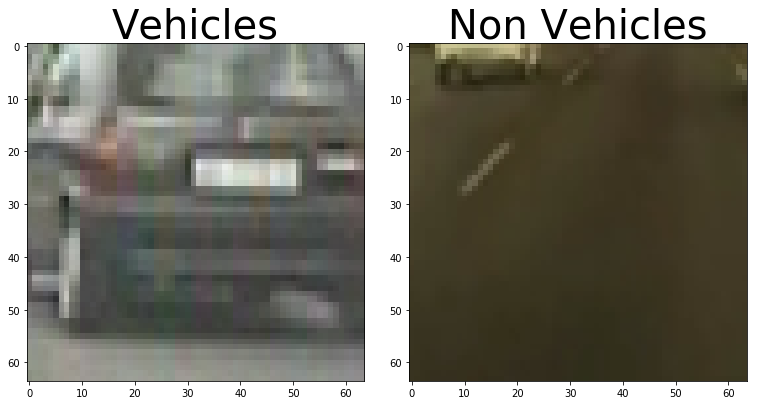

In [1]:
# importing the libraries and printing out some statistics on the data

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import pickle
%matplotlib inline

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time

# Reading the images

import os
def readImages(dir, pattern):
    """
    Returns an image list with the image contained on the directory `dir` matching the `pattern

    """
    images = []
    for dirpath, dirnames, filenames in os.walk(dir):
        for dirname in dirnames:
            images.append(glob.glob(dir + '/' + dirname + '/' + pattern))
    flatten = [item for sublist in images for item in sublist]
    return list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), flatten)),  flatten
    
vehicles, v_raw = readImages('./vehicles', '*.png')
non_vehicles, nv_raw = readImages('./non-vehicles', '*.png')


#printing out some stats and plotting

ind = 20


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
f.tight_layout()
#
ax1.imshow(vehicles[ind])
ax1.set_title('Vehicles', fontsize=40)
#
ax2.imshow(non_vehicles[ind])
ax2.set_title('Non Vehicles', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

n_vehicles= len(vehicles)
n_nonvehicles= len(non_vehicles)

image1 = vehicles[ind]
image2 = non_vehicles[ind]
print('This Vehicle image is:', type(image1), 'with dimensions:', image1.shape)
print('This Non Vehicle image is:', type(image2), 'with dimensions:', image2.shape)
print ('Number of Vehicle Images', n_vehicles)
print ('Number of Non-Vehicle Images', n_nonvehicles)


/Users/architrastogi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


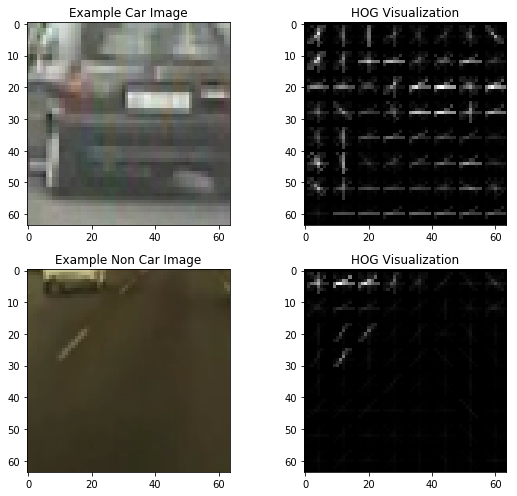

In [12]:
# Following are the functions to extract feature from the image

# function to do the spatial binning on the image and return the feature vector

def bin_spatial(img, size=(32, 32)):
    small_img = cv2.resize(img, size)
    # Use cv2.resize().ravel() to create the feature vector
    features = small_img.ravel() 
    # Return the feature vector
    return features

# Function to generate the color histogram features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    # r,g,b histograms
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Function to generate the hog features 
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block),transform_sqrt=True, 
                          visualise=vis, feature_vector=feature_vec)
                         
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block),transform_sqrt=True, 
                          visualise=vis, feature_vector=feature_vec)
                          
        return features

# Generate a random index to look at a car image
ind = np.random.randint(0, len(vehicles))
# Read in the image

gray1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 8
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features1, hog_image1 = get_hog_features(gray1, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
features2, hog_image2 = get_hog_features(gray2, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

#print(len(features))
# Plot the examples
fig = plt.figure(figsize=(8,7))
plt.subplot(221)
plt.imshow(image1, cmap='gray')
plt.title('Example Car Image')
plt.subplot(222)
plt.imshow(hog_image1, cmap='gray')
plt.title('HOG Visualization')

plt.subplot(223)
plt.imshow(image2, cmap='gray')
plt.title('Example Non Car Image')
plt.subplot(224)
plt.imshow(hog_image2, cmap='gray')
plt.title('HOG Visualization')

plt.tight_layout()

/Users/architrastogi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


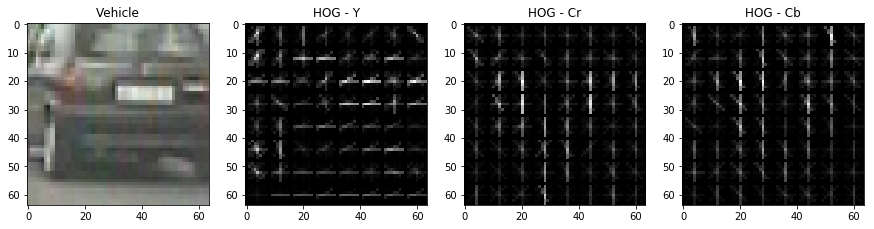

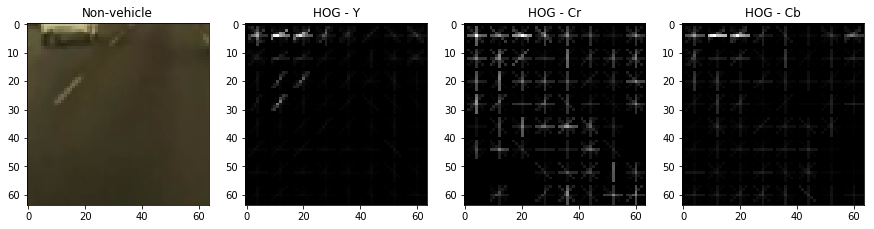

In [13]:
# This function plots the hog features on YCrCb color scheme which is used later as it improves the accuracy 
def showhog(img, orient, pix_per_cell, cell_per_block, title):
    
    img_cspaced = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    _, hog_y = get_hog_features(img_cspaced[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    _, hog_Cr = get_hog_features(img_cspaced[:,:,1],orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

    _, hog_Cb = get_hog_features(img_cspaced[:,:,2],orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

    fig, axes = plt.subplots(ncols=4, figsize=(15,15))
    axes[0].imshow(img)
    axes[0].set_title(title)
    axes[1].imshow(hog_y, cmap='gray')
    axes[1].set_title('HOG - Y')
    axes[2].imshow(hog_Cr, cmap='gray')
    axes[2].set_title('HOG - Cr')
    axes[3].imshow(hog_Cb, cmap='gray')
    axes[3].set_title('HOG - Cb')
    
showhog(image1, orient, pix_per_cell, cell_per_block,'Vehicle')
showhog(image2,orient, pix_per_cell, cell_per_block,'Non-vehicle')
    

In [14]:

# Function to combine all the feature extraction functions and generate a combined feature vector for a particular image
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = file
        
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        feat=np.concatenate((spatial_features, hist_features,hog_features), axis=0)
        features.append(feat)
    # Return list of feature vectors
    return features



In [15]:
# Parameters that are used for extracting the features to generate better accuracy on the classifier 
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

spatial_size=(16,16)
hist_bins=32
hist_range=(0, 256)

t=time.time()

# extracting the features for car/no car images separately
car_features = extract_features(vehicles, cspace=colorspace, spatial_size= spatial_size,hist_bins=hist_bins,hist_range=hist_range, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
notcar_features = extract_features(non_vehicles, cspace=colorspace, spatial_size= spatial_size,hist_bins=hist_bins,hist_range=hist_range, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')


# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float32)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

/Users/architrastogi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


94.25 Seconds to extract features...
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5568
17.97 Seconds to train SVC...
Test Accuracy of SVC =  0.9927
My SVC predicts:  [0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
For these 10 labels:  [0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
0.00223 Seconds to predict 10 labels with SVC


In [16]:

# sliding window to genrate the diffenret windows to be searched based on the given X, Y start/stop 
# and window size and overlap
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [19]:
# Function to generate the feature vector for a single image to be passed on to the classifier
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# function that takes in an image and the windows to be searched and outputs the windows where the classifier predicts positively
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


/Users/architrastogi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


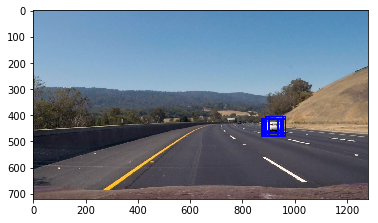

In [22]:
#This block of code takes in the input image from test image folder and shows the output from search window()

folder_out= '/Users/architrastogi/Documents/Vehicle_Identification/CarND-Vehicle-Detection-master/output_images/'
folder_in= '/Users/architrastogi/Documents/Vehicle_Identification/CarND-Vehicle-Detection-master/test_images/'

#filename= 'test1'
#filename= 'test2'
filename= 'test3'
#filename= 'test4'
#filename= 'test5'
#filename= 'test6' 


ext ='.jpg'

image =cv2.cvtColor(cv2.imread(folder_in+filename+ext), cv2.COLOR_BGR2RGB)
#image = image.astype(np.float32)/255



#image = mpimg.imread('bbox-example-image.jpg')
draw_image = np.copy(image)


y_start_stop= [360, 700]
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.85, 0.85))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)



/Users/architrastogi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


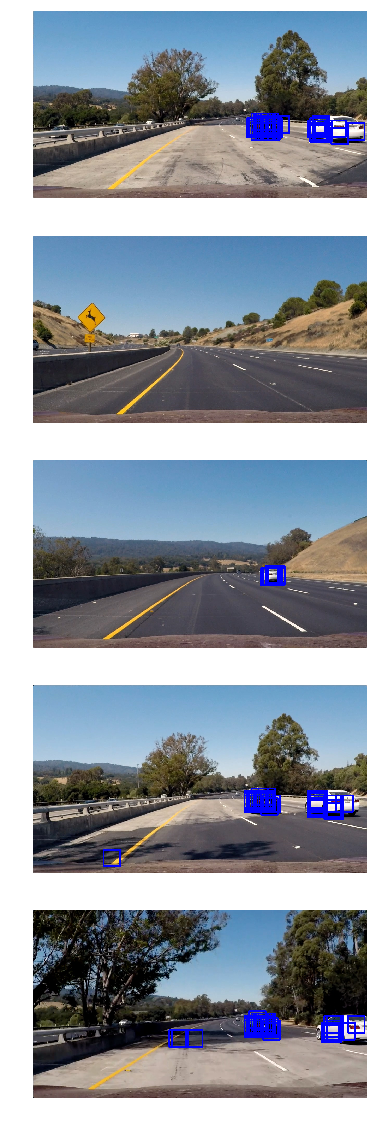

In [25]:
#This block of code takes in all the input images from test image folder and shows the output of the search window() algorithm

import matplotlib.gridspec as gridspec
gs1 = gridspec.GridSpec(5, 1)
gs1.update(wspace=0.01) # set the spacing between axes.
plt.figure(figsize=(30,20))

PATH = "/Users/architrastogi/Documents/Vehicle_Identification/CarND-Vehicle-Detection-master/test_images/"

filename= "test{0:01d}"
ext= ".jpg"

#img_test_x= np.empty((5,32,32,3),dtype=float)
for i in range(5):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    p1 = filename.format(i+1)
    p =PATH+p1+ext
    #img = mpimg.imread(p)
    
    #img_test_x[i]=foo
    image =cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)




    #image = mpimg.imread('bbox-example-image.jpg')
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255
    y_start_stop= [360, 700]
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.85, 0.85))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=colorspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  
    

    plt.subplot(5,1,i+1)
    plt.imshow(window_img)
    plt.axis('off')
    plt.imsave('/Users/architrastogi/Documents/Vehicle_Identification/CarND-Vehicle-Detection-master/output_images/'+p1+'hog_sampled'+ext,window_img)
   

plt.show()

In [26]:

#filename= 'test4'
filename= 'test5'
#filename= 'test6' 


ext ='.jpg'

image =cv2.cvtColor(cv2.imread(folder_in+filename+ext), cv2.COLOR_BGR2RGB)

# Function to change the color scheme
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


# A single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    car_boxes= []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                car_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img, car_boxes
    
ystart = 360
ystop = 656
scale = 1.5
    
#out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
out_img, out_box = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

#plt.imshow(out_img)





/Users/architrastogi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


/Users/architrastogi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


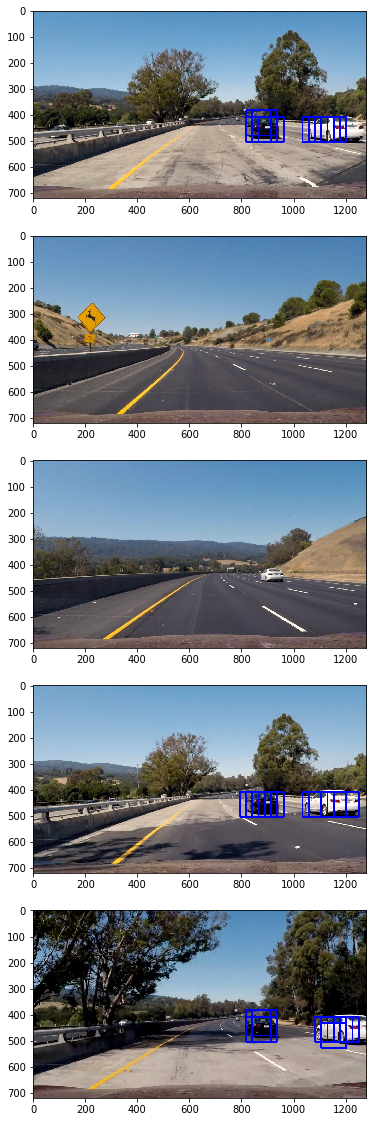

In [27]:
#This block of code takes in all the input images from test image folder and shows the output of the hog subsampling algorithm

gs1 = gridspec.GridSpec(5, 1)
gs1.update(wspace=0.01) # set the spacing between axes.
plt.figure(figsize=(30,20))

PATH = "/Users/architrastogi/Documents/Vehicle_Identification/CarND-Vehicle-Detection-master/test_images/"

filename= "test{0:01d}"
ext= ".jpg"

#img_test_x= np.empty((5,32,32,3),dtype=float)
for i in range(5):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    p1 = filename.format(i+1)
    
    p =PATH+p1+ext
    image =cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)

    out_img, out_box = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)


    plt.subplot(5,1,i+1)
    plt.imshow(out_img)
    plt.imsave('/Users/architrastogi/Documents/Vehicle_Identification/CarND-Vehicle-Detection-master/output_images/'+p1+'hog_subsampled'+ext,out_img)
   

plt.show()

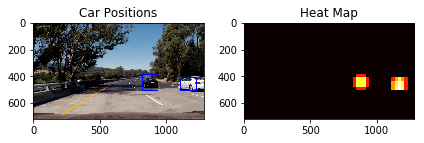

In [28]:
# This block of the code generates heatmaps to remove false positives in the Vehicle Identification

heat = np.zeros_like(image[:,:,0]).astype(np.float)
from scipy.ndimage.measurements import label


# Function to update the heatmap
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

#Applying minimum threshold to the heatmap in order to be selected as the vehicle
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Creating a single labeled box for a car
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


# Add heat to each box in box list
heat = add_heat(heat,out_box)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)


fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

/Users/architrastogi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/Users/architrastogi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


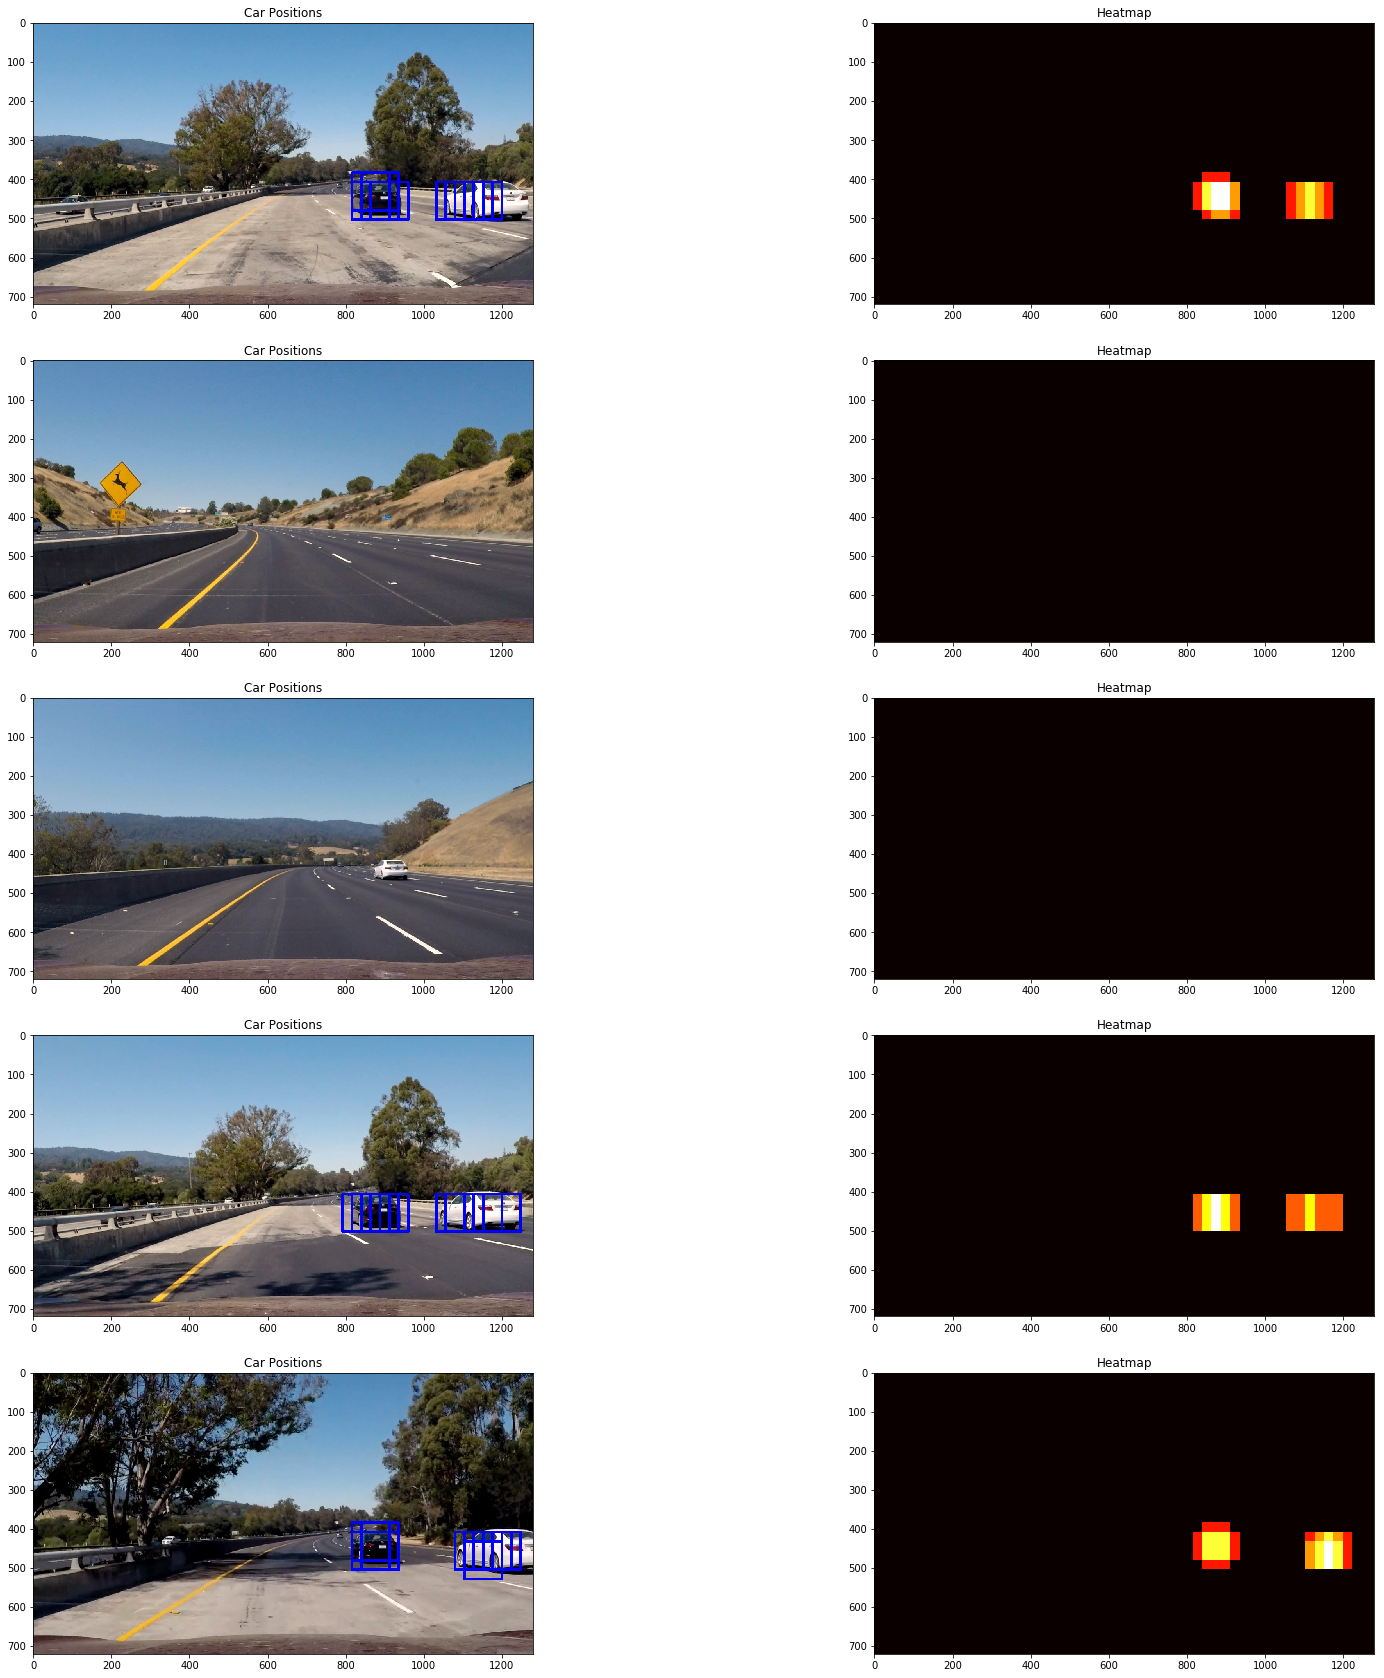

In [29]:
# THis block of the code plots the single vehcile box and the heatmap for all the test images

gs1 = gridspec.GridSpec(5, 2)
gs1.update(wspace=0.01) # set the spacing between axes.
plt.figure(figsize=(30,30))

PATH = "/Users/architrastogi/Documents/Vehicle_Identification/CarND-Vehicle-Detection-master/test_images/"

filename= "test{0:01d}"
ext= ".jpg"

for i in range(5):

    p1 = filename.format(i+1)
    
    p =PATH+p1+ext

    image =cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    out_img, out_box = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    img_shape= image.shape
    # Add heat to each box in box list
    heat = add_heat(heat,out_box)

    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    
    ax1 = plt.subplot(gs1[i,0])
    ax1.set_aspect('equal') 
    ax1.imshow(out_img)
    ax1.set_title('Car Positions')
    
    ax2 = plt.subplot(gs1[i,1])
    ax2.set_aspect('equal')
    ax2.imshow(heatmap, cmap= 'hot')
    ax2.set_title('Heatmap')
    plt.tight_layout()
    plt.imsave('/Users/architrastogi/Documents/Vehicle_Identification/CarND-Vehicle-Detection-master/output_images/'+p1+'heatmap'+ext,heatmap)
   
plt.show()

In [14]:
#Video Pipeline 
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from functools import reduce


# Single function to be applied to each frame of the video
def process_image(image):
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    out_img, out_box = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    img_shape= image.shape
    # Add heat to each box in box list
    heat = add_heat(heat,out_box)

    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img







# writing the video file after applying process_image to every frame in the video

inputvideo= '/Users/architrastogi/Documents/advanced_lane_lines/CarND-Advanced-Lane-Lines-master/project_output_video.mp4'
outputvideo= '/Users/architrastogi/Documents/Vehicle_Identification/CarND-Vehicle-Detection-master/output1.mp4'
myclip = VideoFileClip(inputvideo)
clip = myclip.fl_image(process_image)
%time clip.write_videofile(outputvideo, audio=False)
            

[MoviePy] >>>> Building video /Users/architrastogi/Documents/Vehicle_Identification/CarND-Vehicle-Detection-master/output1.mp4
[MoviePy] Writing video /Users/architrastogi/Documents/Vehicle_Identification/CarND-Vehicle-Detection-master/output1.mp4


100%|█████████▉| 1260/1261 [10:40<00:00,  2.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /Users/architrastogi/Documents/Vehicle_Identification/CarND-Vehicle-Detection-master/output1.mp4 

CPU times: user 10min 13s, sys: 17.7 s, total: 10min 30s
Wall time: 10min 41s
